In [1]:
### code to make one mixed csv training file from the training dataset

import pandas as pd
import os

pos_directory = 'OneDrive/Dokumente/UH/Fall 24/ICS 661 AI/Assignment 2/train/pos/'
neg_directory = 'OneDrive/Dokumente/UH/Fall 24/ICS 661 AI/Assignment 2/train/neg/'

pos_file_paths = [os.path.join(pos_directory, f) for f in os.listdir(pos_directory)]
neg_file_paths = [os.path.join(neg_directory, f) for f in os.listdir(neg_directory)]


data = {
    'text': [],
    'label': [] 
}

for i,f in enumerate(pos_file_paths):
    with open(f, 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()
        
    data['text'].append(text)
    data['label'].append(1)
    
    with open(neg_file_paths[i], 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()
        
    data['text'].append(text)
    data['label'].append(0)

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV file
df.to_csv('data_mixed.csv', index=False)


In [2]:
###function to do metrics

from datasets import load_metric
import torch

# Load metrics
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to a PyTorch tensor
    logits = torch.tensor(logits)
    labels = torch.tensor(labels)
    predictions = torch.argmax(logits, dim=-1)
    
    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")

    
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"],
    }

C:\Users\marks\AppData\Local\Temp\ipykernel_27936\3283160295.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


C:\Users\marks\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the ch

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

C:\Users\marks\anaconda3\Lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.589100,0.346301,0.890000,0.890022,0.890756,0.890000
2,0.287300,0.296991,0.895000,0.894761,0.902157,0.895000
3,0.150800,0.296054,0.915000,0.915011,0.916165,0.915000
4,0.072300,0.376341,0.910000,0.909837,0.911325,0.910000
5,0.038100,0.406512,0.915000,0.915019,0.915450,0.915000


ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

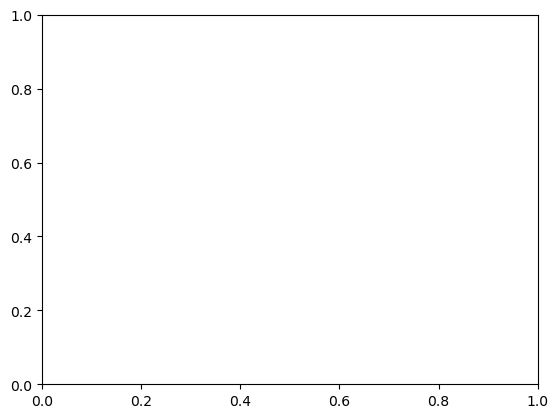

In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import EarlyStoppingCallback

# Load data
data = pd.read_csv('data_mixed.csv')
data = data.iloc[:1000, :]
train_texts, val_texts, train_labels, val_labels = train_test_split(data['text'], data['label'], test_size=0.2)

# Convert to Hugging Face's Dataset format
train_data = Dataset.from_pandas(pd.DataFrame({'text': train_texts, 'label': train_labels}))
val_data = Dataset.from_pandas(pd.DataFrame({'text': val_texts, 'label': val_labels}))

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize data
def preprocess_data(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

train_data = train_data.map(preprocess_data, batched=True)
val_data = val_data.map(preprocess_data, batched=True)

# Set format for PyTorch tensors
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",  
    logging_dir='./logs',
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.1,
    load_best_model_at_end=True,  # Automatically loads the best model at the end
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)], 
)

# Train the model
trainer.train()

# Metrics and Plots
logs = trainer.state.log_history
epochs = list(range(1, training_args.num_train_epochs + 1))

train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
accuracy = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
f1 = [log["eval_f1"] for log in logs if "eval_f1" in log]
precision = [log["eval_precision"] for log in logs if "eval_precision" in log]
recall = [log["eval_recall"] for log in logs if "eval_recall" in log]

# Plot the loss values
plt.figure()
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, accuracy, label="Accuracy", marker='o')
plt.plot(epochs, f1, label="F1 Score", marker='o')
plt.plot(epochs, precision, label="Precision", marker='o')
plt.plot(epochs, recall, label="Recall", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Metrics Over Epochs")
plt.legend()
plt.show()

# Save the model
model.save_pretrained('./binary_classification_model')
tokenizer.save_pretrained('./binary_classification_model')


In [4]:
torch.cuda.empty_cache()